In [1]:
import pandas as pd
import torch
from chronos import BaseChronosPipeline
import tqdm as notebook_tqdm

import numpy as np
import pandas as pd

import Utils 
from Utils import calculateEMA, calculateBB, addPreviousDays, removeColumns, getPeriod, mape, mae, createDate, getDate, printResult

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')
import pdb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

c:\Users\Rodrigo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dfColumns = ['date','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']
col15 = ['open','d-5_high','d-5_low','d-4_high','d-4_low','d-3_high','d-3_low','d-2_high','d-2_low','d-1_high','d-1_low','EMA_high','EMA_low','UB_close','LB_close']
col25 = ['open','d-5_open','d-5_high','d-5_low','d-5_close','d-4_open','d-4_high','d-4_low','d-4_close','d-3_open','d-3_high','d-3_low','d-3_close','d-2_open','d-2_high','d-2_low','d-2_close','d-1_open','d-1_high','d-1_low','d-1_close','EMA_high' ,'EMA_low','UB_close','LB_close']
DAYS = 5
TEST_BEGIN = '2021.04.06'
TEST_END = '2021.06.01'
TRAIN_BEGIN = '2018.03.30'
TRAIN_END = '2021.04.05'
TIMES = 10

In [3]:
def create_df(fundo):
    df = pd.read_csv(f'../Data/{fundo}_Daily.csv', sep = "\t")
    df.columns = dfColumns
    df = removeColumns(df, ['tickvol', 'volume','spread'])
    df = calculateEMA(df,DAYS,newColumns)
    df = calculateBB(df,DAYS,newColumns)
    df = addPreviousDays(df,DAYS, newColumns)
    initialDf_ = getPeriod(df, '2017.06.01','2021.06.01', True)
    return initialDf_

In [5]:
def exp_chronos(df, target_col='open', normalizer='', 
                train_start='2018.04.02', train_end='2021.02.03',
                valid_start='2021.02.04', valid_end='2021.04.05',
                test_start='2021.04.06', test_end='2021.06.01',
                prediction_length=5):

    # 1. Separar os períodos
    df_train = getPeriod(df, train_start, valid_end)
    df_test  = getPeriod(df, test_start, test_end)

    # 2. Selecionar a série alvo
    y_train = df_train[target_col].values
    y_test  = df_test[target_col].values

    # 3. Preparar entrada para Chronos
    serie_torch = torch.tensor(y_train, dtype=torch.float32)
    
    pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-t5-small", device_map="auto")
    quantiles, mean = pipeline.predict_quantiles(
        context=serie_torch,
        prediction_length=prediction_length,
        quantile_levels=[0.1, 0.5, 0.9]
    )

    #4.Resultados
    y_pred_mean = mean[0].numpy()
    y_test_orig = y_test[-prediction_length:]
    q10 = quantiles[0, :, 0].numpy()
    q90 = quantiles[0, :, 2].numpy()
    uncertainty = q90 - q10

    return [y_test_orig, y_pred_mean, uncertainty]

In [8]:
def runPrediction(fundo):
    df = create_df(fundo)

    orig_high, pred_high, uncertainty_high = exp_chronos(df, prediction_length=40, target_col='high')
    orig_low, pred_low, uncertainty_low = exp_chronos(df, prediction_length=40, target_col='low')

    return [orig_high, pred_high, uncertainty_high, orig_low, pred_low, uncertainty_low]
    

In [9]:
def generatePlot(y_test_orig, y_pred_mean, uncertainty, target_col, fundo): 

    # Criar eixo de tempo
    dias = np.arange(len(y_test_orig))

    # Calcular faixa de incerteza (intervalo 90% - 10%)
    inferior = y_pred_mean - (uncertainty / 2)
    superior = y_pred_mean + (uncertainty / 2)

    plt.figure(figsize=(10, 6))

    # Linha real (azul)
    plt.plot(dias, y_test_orig, label='Valor Real', color='blue', marker='o')

    # Linha prevista (laranja)
    plt.plot(dias, y_pred_mean, label='Previsão Média', color='red', marker='o')

    # Faixa de incerteza (sombreada)
    plt.fill_between(dias, inferior, superior, color='orange', alpha=0.3, label='Incerteza (10%-90%)')

    # Rótulos e legendas
    plt.title(f'Previsão com Chronos vs Valor Real {fundo}')
    plt.xlabel('Dias')
    plt.ylabel('Preço (' + target_col + ')')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [10]:
df = pd.read_csv('../Data/PETR4_Daily.csv', sep = "\t")
df.columns = dfColumns
df = removeColumns(df, ['tickvol', 'volume','spread'])

df 
df.tail(290)

,date,open,high,low,close
1049,2020.03.31,13.16,14.07,13.16,13.54
1050,2020.04.01,13.01,14.08,12.89,13.84
1051,2020.04.02,14.90,16.01,14.52,15.01
1052,2020.04.03,15.77,15.83,14.44,14.84
1053,2020.04.06,15.53,15.58,14.69,15.26
...,...,...,...,...,...
1334,2021.05.26,25.91,26.18,25.65,26.09
1335,2021.05.27,26.08,26.25,25.77,25.91
1336,2021.05.28,26.20,27.02,26.15,26.99
1337,2021.05.31,26.96,27.20,26.78,26.87


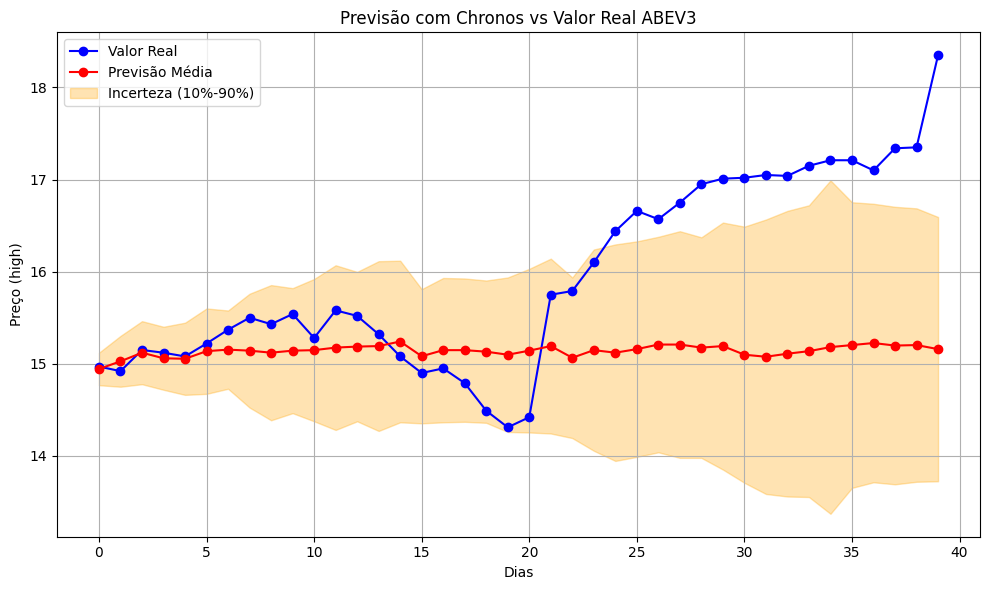

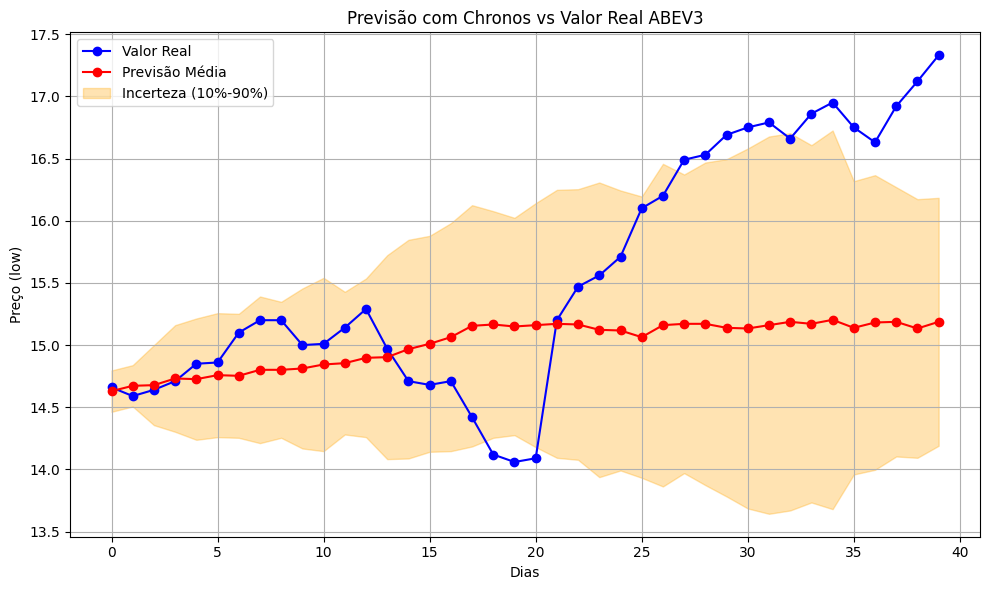

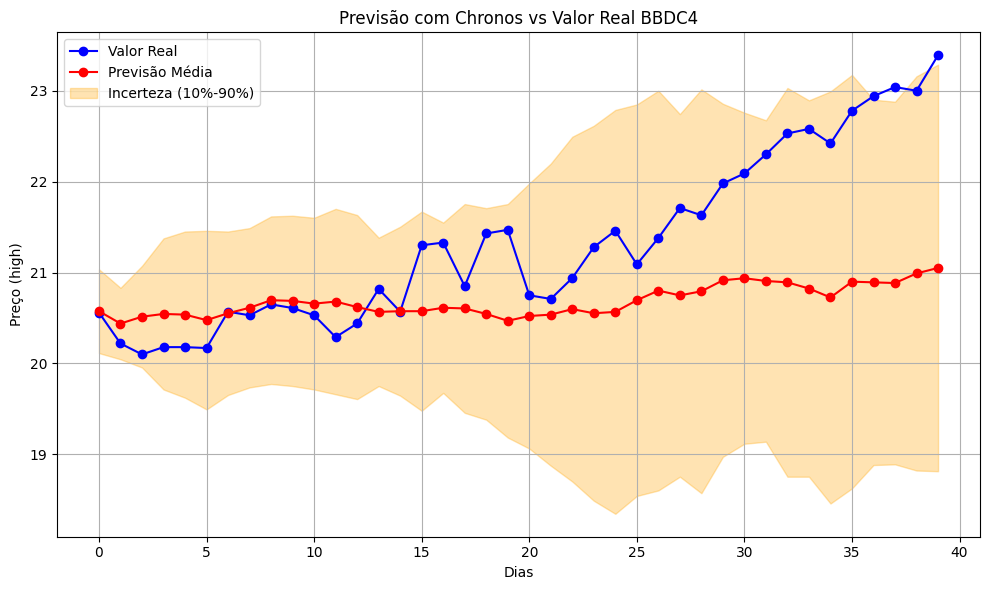

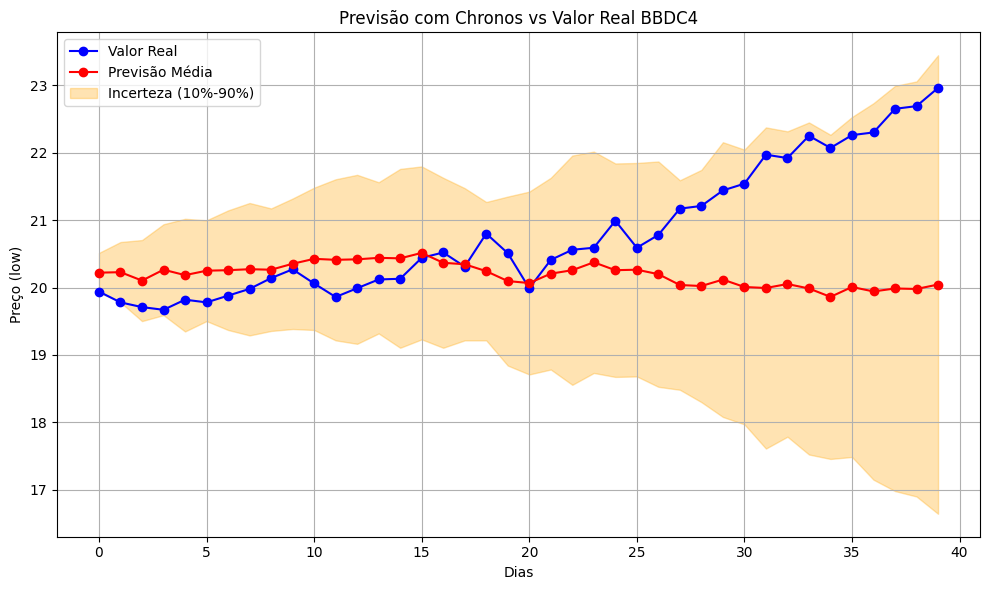

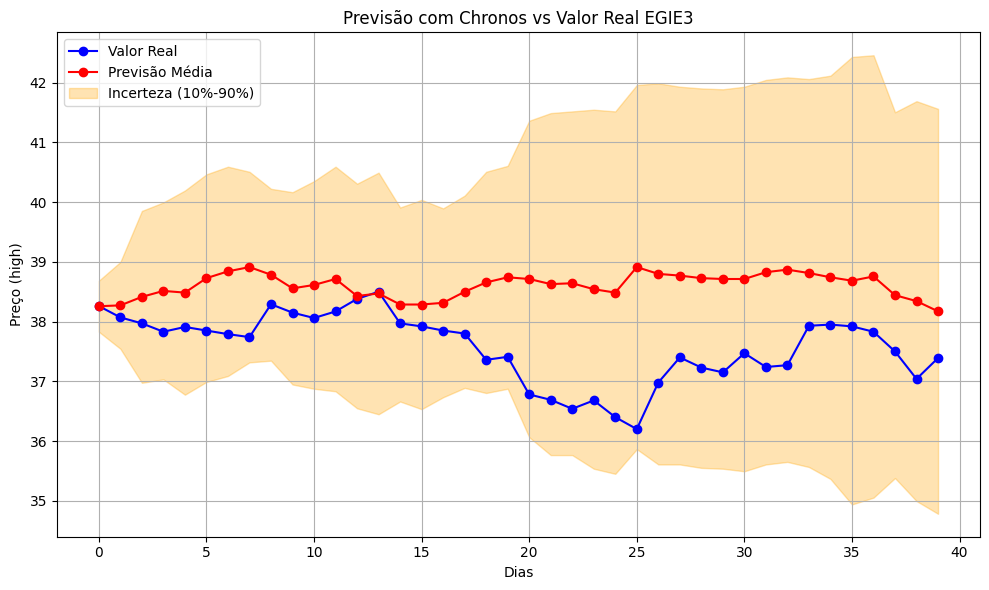

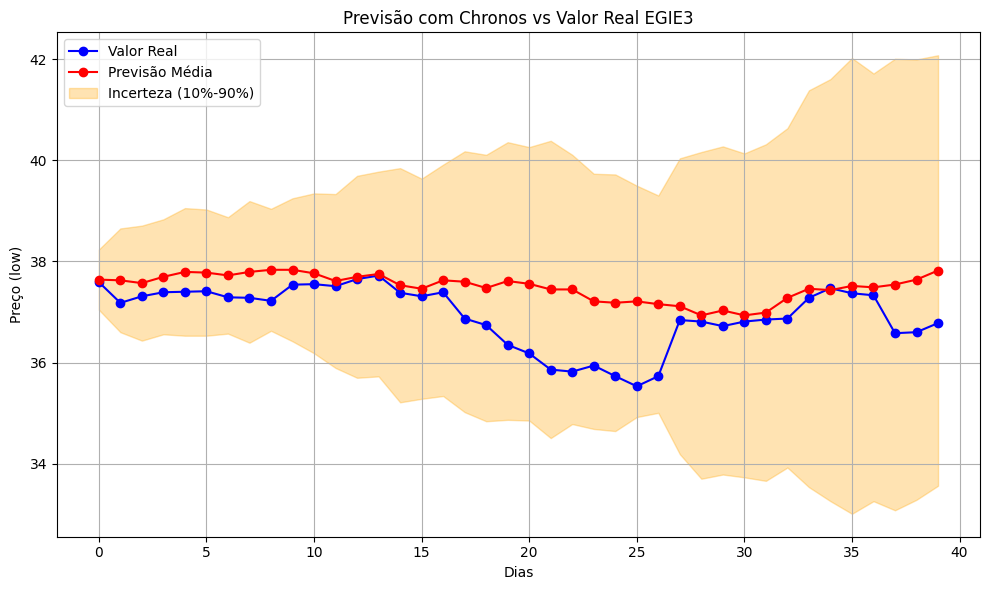

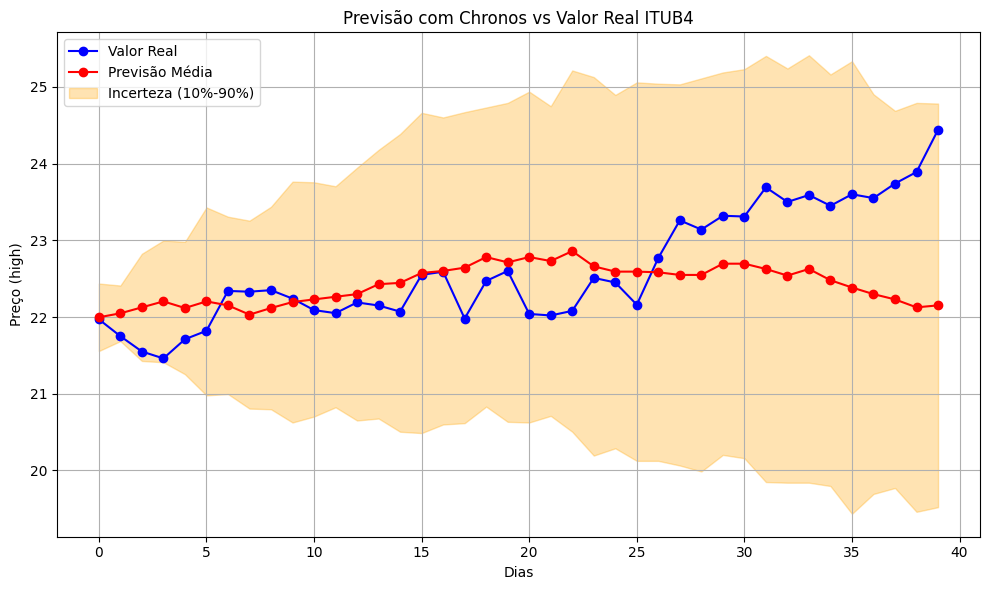

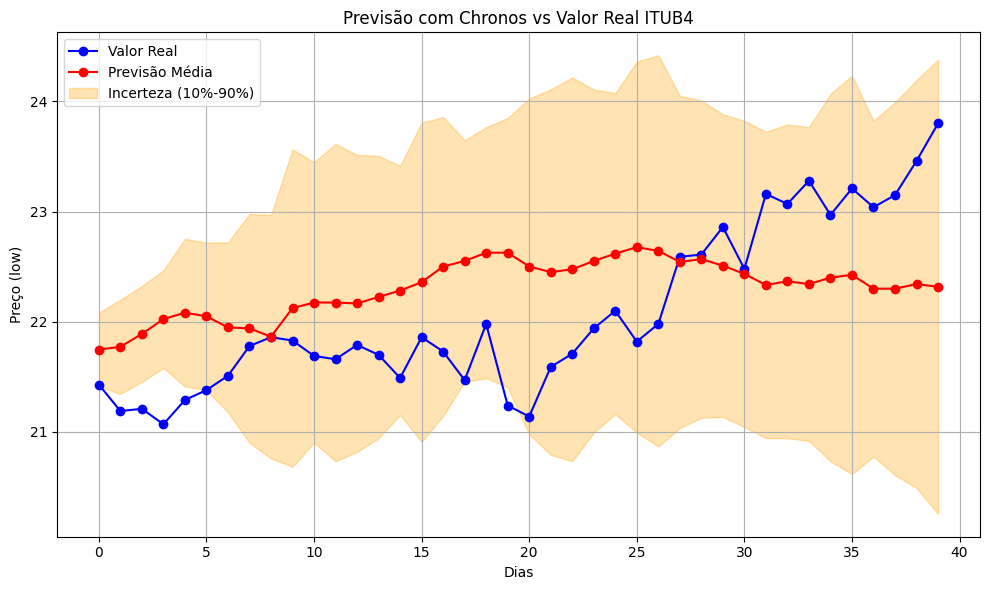

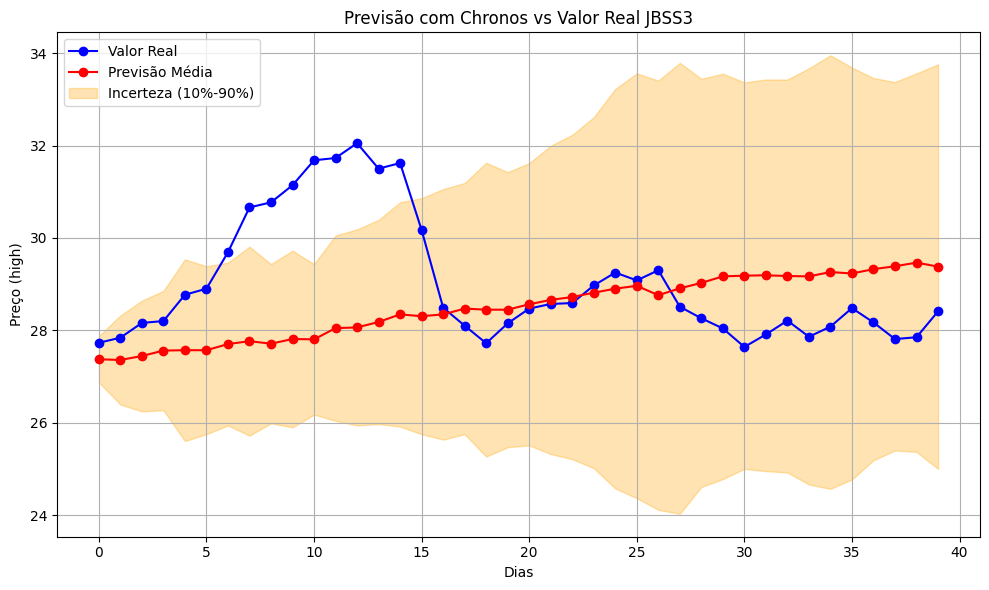

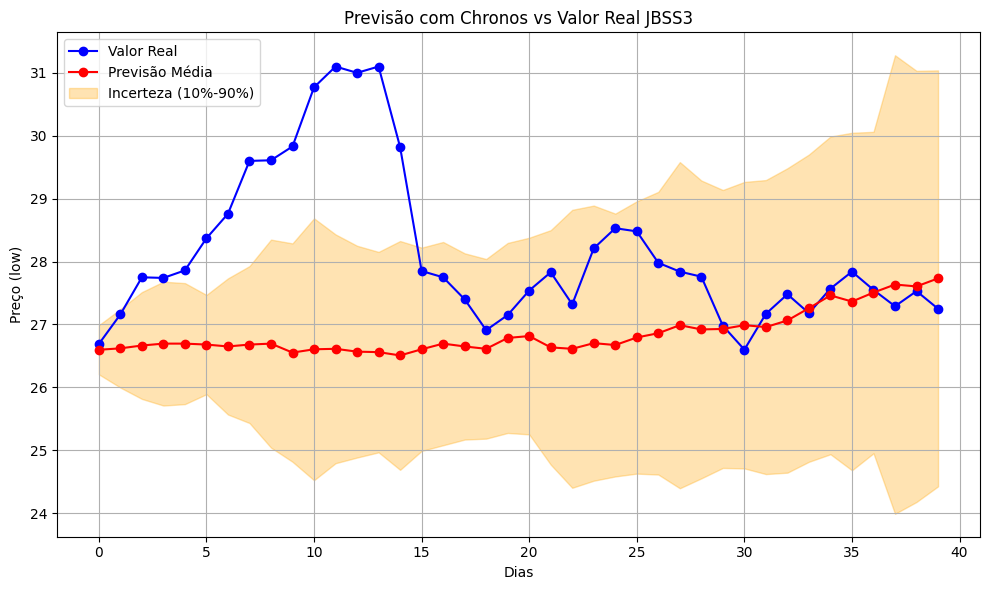

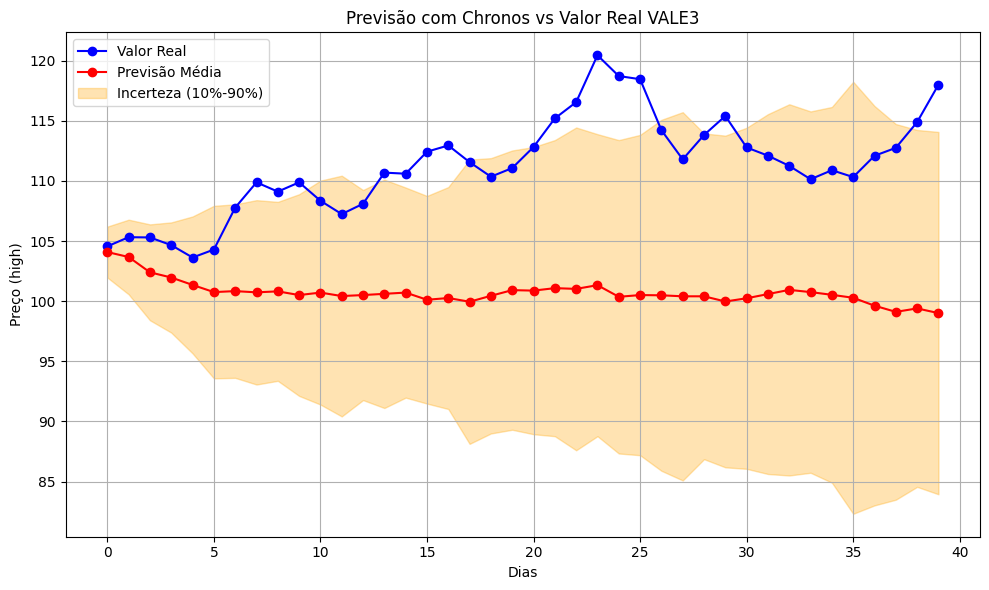

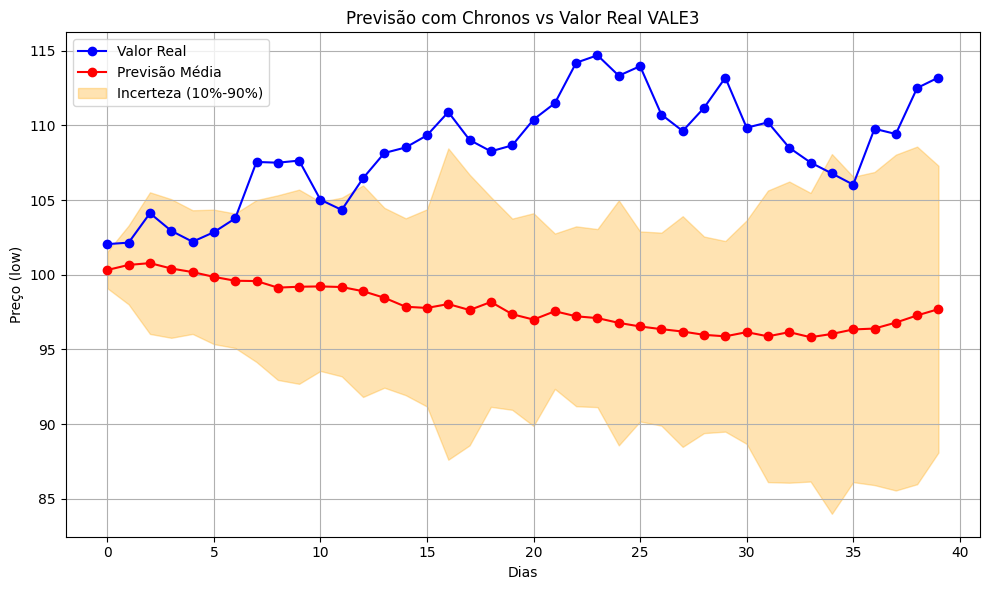

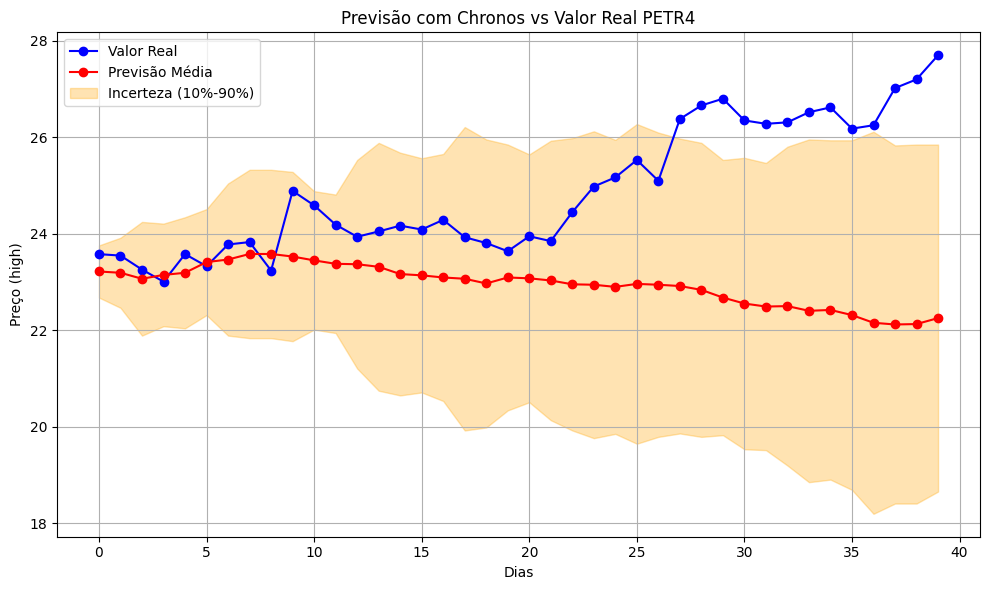

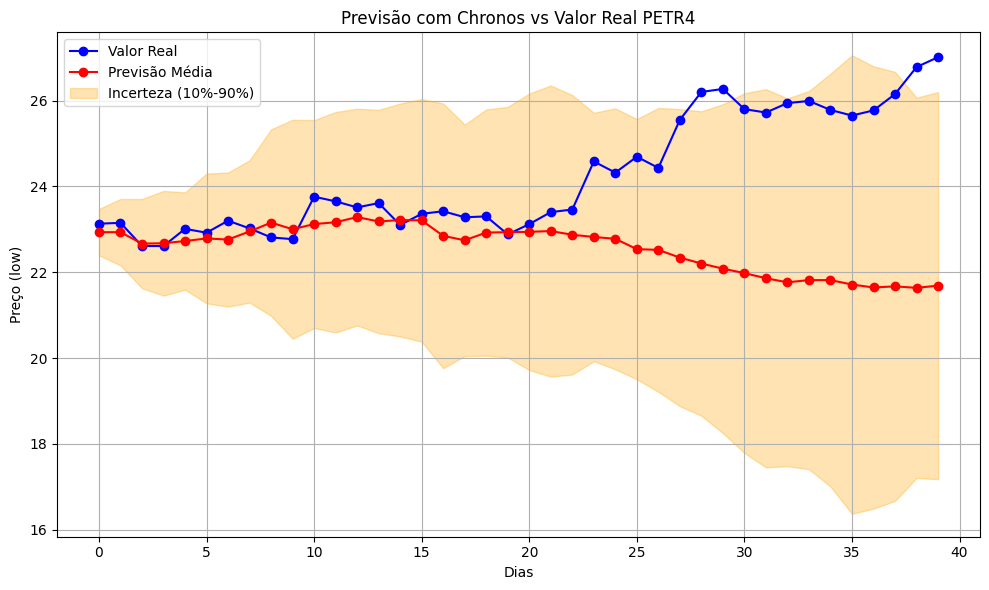

In [11]:
fundos = ['ABEV3', 'BBDC4', 'EGIE3', 'ITUB4', 'JBSS3', 'VALE3', 'PETR4']
for name in fundos:
    orig_high, pred_high, uncertainty_high, orig_low, pred_low, uncertainty_low = runPrediction(name)

    generatePlot(orig_high, pred_high, uncertainty_high, 'high', name)
    generatePlot(orig_low, pred_low, uncertainty_low, 'low', name)

    result_prediction = pd.DataFrame()
    result_prediction['date'] = getPeriod(df, TEST_BEGIN, TEST_END)['date']
    result_prediction['high_pred'] = pred_high
    result_prediction['low_pred'] = pred_low
    result_prediction['uncertainty_high'] = uncertainty_high
    result_prediction['uncertainty_low'] = uncertainty_low
    result_prediction['uncertainty_mean'] = (result_prediction['uncertainty_high'] + result_prediction['uncertainty_low']) / 2
    #result_prediction['uncertainty_valid_mean'] = (f[:,0] + f[:,1]) / 2
    result_prediction['high'] = orig_high
    result_prediction['low'] = orig_low
    result_prediction.to_pickle(f'../Data/{name}_Pred_No_Finetuning.pkl')


Você está dizendo:

Me mostre, para os próximos 5 dias:

O valor mais pessimista (quantil 0.1)

O valor mais provável (mediana, quantil 0.5)

O valor mais otimista (quantil 0.9)

📊 Exemplo numérico (dia 1)
Quantil	Valor	Interpretação
0.1	    23.1	10% das previsões ficam abaixo de 23.1 → valor conservador
0.5	    24.0	Previsão mais provável (mediana)
0.9	    25.4	90% das previsões ficam abaixo de 25.4 → valor otimista
